In [1]:
import numpy as np
import torch
import torchvision as tv
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sim_in = 20 * torch.rand((1000, 1)) - 10
groundTruth = np.cos(sim_in)

In [3]:
def calcParams(inputModel):
    val = sum(params.numel() for params in inputModel.parameters() if params.requires_grad)
    return val

In [4]:
# Set up NN for cos(x) training - 2 Hidden Layers, 32 parameters - Shallow Network
class OptimizeNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 12)
        self.fc2 = nn.Linear(12, 6)
        self.fc3 = nn.Linear(6, 1)

    def forward(self, val):
        val = F.relu(self.fc1(val))
        val = F.relu(self.fc2(val))
        val = self.fc3(val)
        return val

In [5]:
optimNet = OptimizeNN()
costFunc = nn.MSELoss()
opt = optim.Adam(optimNet.parameters(), lr=0.001)

In [6]:
def min_ratio(w):
    count = 0
    total = 0
    for x in w:
        if(x>0):
            count += 1
        total +=1
    return count/ total

In [7]:
def calculate_grad_norm(model):

    grads = []
    for p in model.modules():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) # compute mean of gradient norms
    return grad_mean

In [8]:
minRatio = []
Loss = []
train_count = 100
for i in range(train_count):
    EPOCHS = 100
    lss = 0
    # Set up necessary auxilaries for neural net training
    optimNet = OptimizeNN()
    costFunc = nn.MSELoss()
    opt = optim.Adam(optimNet.parameters(), lr=0.001)
    for epochIndex in range(EPOCHS):
        optimNet.zero_grad()
        output = optimNet(sim_in)
        cost = costFunc(output, groundTruth)
        with torch.no_grad():
            lss += (costFunc(output, groundTruth))
        cost.backward()
        opt.step()
    #print(calculate_grad_norm(optimNet))
    Loss.append(lss/len(sim_in))
    num_param = calcParams(optimNet)
    
    # Allocate Hessian size
    H = torch.zeros((num_param, num_param))

    y_hat = optimNet(sim_in)
    y = sim_in
    loss  = ((y_hat - y)**2).mean()
    # Calculate Jacobian w.r.t. model parameters
    J = torch.autograd.grad(loss, list(optimNet.parameters()), create_graph=True)
    J = torch.cat([e.flatten() for e in J]) # flatten

    # Fill in Hessian
    num_param = calcParams(optimNet)
    for i in range(num_param):
        result = torch.autograd.grad(J[i], list(optimNet.parameters()), retain_graph=True)
        H[i] = torch.cat([r.flatten() for r in result]) # flatten
    w, v = np.linalg.eig(H)
    minRatio.append(min_ratio(w))
    #print(min_ratio(w))

/home/skomara/.local/lib/python3.9/site-packages/torch/autograd/graph.py:769: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [9]:
num_param = calcParams(optimNet)

In [10]:
H = torch.zeros((num_param, num_param))

y_hat = optimNet(sim_in)
y = sim_in
loss  = ((y_hat - y)**2).mean()

J = torch.autograd.grad(loss, list(optimNet.parameters()), create_graph=True)
J = torch.cat([e.flatten() for e in J]) # flatten


for i in range(num_param):
    result = torch.autograd.grad(J[i], list(optimNet.parameters()), retain_graph=True)
    H[i] = torch.cat([r.flatten() for r in result]) # flatten

Text(0, 0.5, 'Loss')

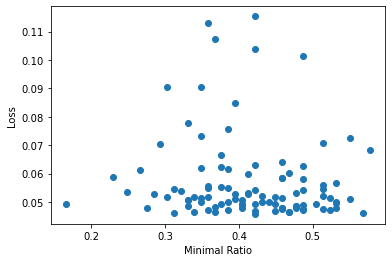

In [11]:
plt.scatter(minRatio, Loss)
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')